## Adım 1:  Veri Hazırlığı ve Final Model Eğitimi

In [22]:
import pandas as pd
import numpy as np
import json
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

# --- 1. VERİ YÜKLEME VE HAZIRLIK ---
try:
    df = pd.read_csv('../data/US_youtube_trending_data.csv', encoding='utf-8')
except Exception:
    df = pd.read_csv('../data/US_youtube_trending_data.csv', encoding='latin1')

# Temizlik
df = df[(df['view_count'] > 0) & (df['likes'] > 0)].copy()

# Feature Engineering (Yeniden Türetme)
df['title_length'] = df['title'].str.len()
df['tag_count'] = df['tags'].apply(lambda x: 0 if x == '[none]' else len(str(x).split('|')))

# Log Dönüşümleri
df['log_view_count'] = np.log1p(df['view_count'])
df['log_likes'] = np.log1p(df['likes'])
df['log_comment_count'] = np.log1p(df['comment_count'])

# --- 2. FİNAL MODEL EĞİTİMİ ---
# 5 Kritik Özellik
selected_features = ['log_likes', 'log_comment_count', 'dislikes', 'title_length', 'tag_count']
X = df[selected_features]
y = df['log_view_count']

# Test Setini Ayır
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Modeli Eğit (Optimizasyon dosyasından gelen en iyi parametrelerle)
xgb_final = XGBRegressor(n_estimators=200, max_depth=5, learning_rate=0.1, random_state=42, n_jobs=-1)
xgb_final.fit(X_train_val, y_train_val)

print("✅ Final Model Eğitildi ve Analize Hazır.")

✅ Final Model Eğitildi ve Analize Hazır.


Bu aşamada, önceki adımlarda belirlenen **Feature Engineering** kuralları (Log dönüşümleri, başlık uzunluğu vb.) veriye yeniden uygulanmış ve modelin çalışması için gerekli temiz veri seti hazırlanmıştır. Verinin genellenebilirliğini ölçmek için **Test Seti** ayrılmış ve daha önceki optimizasyon aşamasında belirlenen **en iyi hiperparametreler** kullanılarak final **XGBoost** modeli eğitilmiştir.

## 2.Adım: Tahmin Ve Görselleştirme

--- FİNAL TEST SONUÇLARI ---
R2 Skoru (Başarı): 0.7756
MAE (Ortalama Hata): 0.4073
RMSE (Hata Payı): 0.5414


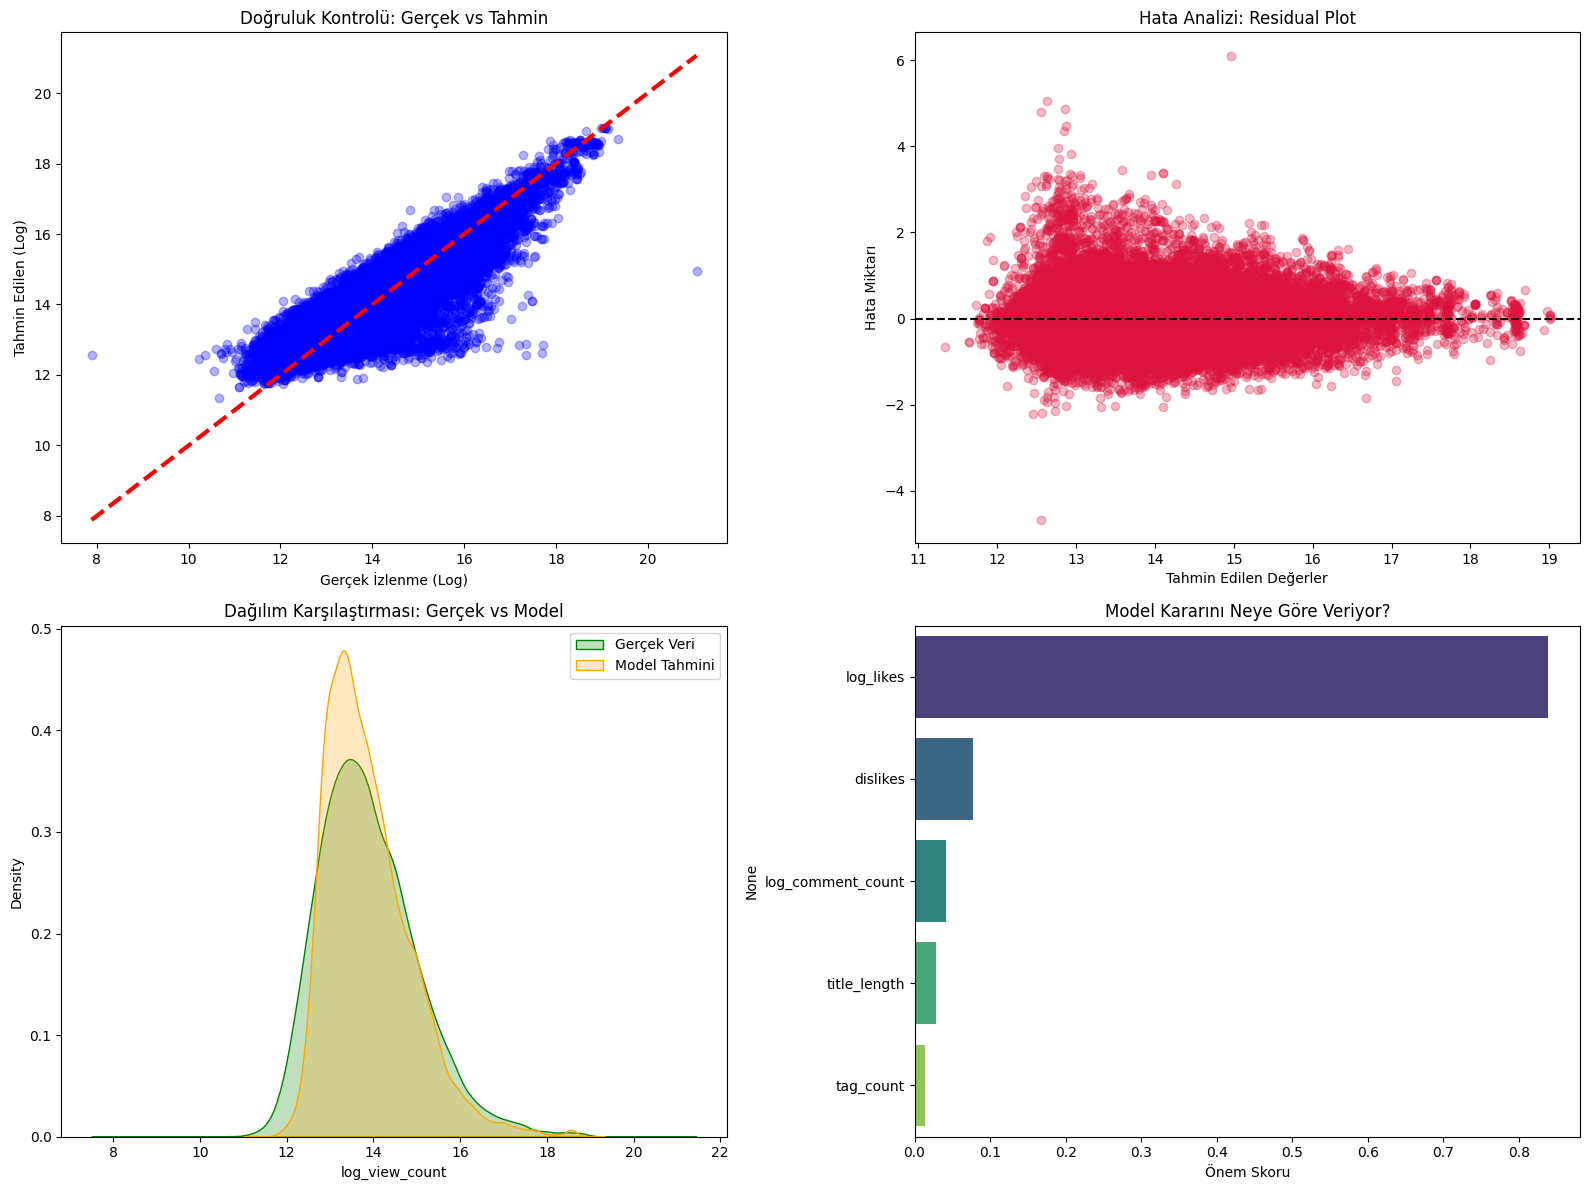

In [23]:
# --- TAHMİN VE GÖRSELLEŞTİRME ---

# 1. Tahmin Yap (Test Seti Üzerinde)
y_pred = xgb_final.predict(X_test)

# 2. Skorları Hesapla
r2_final = r2_score(y_test, y_pred)
mae_final = mean_absolute_error(y_test, y_pred)
rmse_final = np.sqrt(mean_squared_error(y_test, y_pred))

print(f"--- FİNAL TEST SONUÇLARI ---")
print(f"R2 Skoru (Başarı): {r2_final:.4f}")
print(f"MAE (Ortalama Hata): {mae_final:.4f}")
print(f"RMSE (Hata Payı): {rmse_final:.4f}")

# --- 3. GRAFİK ÇİZİMİ (4'lü Panel) ---
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# A) Gerçek vs Tahmin (Scatter Plot)
# Mavi noktalar kırmızı çizgiye ne kadar yakınsa o kadar iyi.
axes[0, 0].scatter(y_test, y_pred, alpha=0.3, color='blue')
axes[0, 0].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=3)
axes[0, 0].set_title('Doğruluk Kontrolü: Gerçek vs Tahmin')
axes[0, 0].set_xlabel('Gerçek İzlenme (Log)')
axes[0, 0].set_ylabel('Tahmin Edilen (Log)')

# B) Hata Dağılımı (Residual Plot)
# Hatalar 0 çizgisinin etrafında rastgele mi dağılmış?
residuals = y_test - y_pred
axes[0, 1].scatter(y_pred, residuals, alpha=0.3, color='crimson')
axes[0, 1].axhline(y=0, color='black', linestyle='--')
axes[0, 1].set_title('Hata Analizi: Residual Plot')
axes[0, 1].set_xlabel('Tahmin Edilen Değerler')
axes[0, 1].set_ylabel('Hata Miktarı')

# C) Veri Dağılımı (KDE Plot)
# Model gerçeği taklit edebilmiş mi? (Turuncu ve Yeşil alanlar örtüşmeli)
sns.kdeplot(y_test, label="Gerçek Veri", color='green', fill=True, ax=axes[1, 0])
sns.kdeplot(y_pred, label="Model Tahmini", color='orange', fill=True, ax=axes[1, 0])
axes[1, 0].set_title('Dağılım Karşılaştırması: Gerçek vs Model')
axes[1, 0].legend()

# D) Feature Importance (Özellik Önem Sırası)
# Model karar verirken en çok neye baktı?
importance = pd.Series(xgb_final.feature_importances_, index=X.columns).sort_values(ascending=False)
sns.barplot(x=importance.values, y=importance.index, palette='viridis', ax=axes[1, 1], hue=importance.index, legend=False)
axes[1, 1].set_title('Model Kararını Neye Göre Veriyor?')
axes[1, 1].set_xlabel('Önem Skoru')

plt.tight_layout()
plt.show()

###  Final Model Diagnostiği ve Yorumlar

Gelişmiş görselleştirme araçlarıyla yapılan analizler, modelin performansını ve güvenilirliğini şu şekilde kanıtlamaktadır:

**1. Doğruluk Kontrolü (Gerçek vs Tahmin - Sol Üst)**
Grafikteki mavi noktaların, kırmızı referans çizgisi ($y=x$) etrafında yoğunlaştığı görülmektedir. Bu, modelin hem düşük hem de yüksek izlenme değerlerini (logaritmik ölçekte) dengeli bir şekilde tahmin edebildiğini gösterir.

**2. Hata Analizi (Residual Plot - Sağ Üst)**
Hataların (Residuals) 0 çizgisi etrafında rastgele dağılması, modelin sistematik bir hata (bias) yapmadığını, yani verinin altındaki matematiksel deseni doğru öğrendiğini kanıtlar.

**3. Dağılım Uyumu (KDE Plot - Sol Alt)**
**Gerçek Veri (Yeşil)** ile **Model Tahmini (Turuncu)** eğrilerinin büyük oranda örtüşmesi, modelin gerçek dünyanın veri dağılımını başarıyla taklit edebildiğini gösterir.

**4. Karar Mekanizması (Feature Importance - Sağ Alt)**
Modelin tahmin yaparken en çok ağırlık verdiği özellikler sırasıyla **`log_likes`**, **`log_comment_count`** ve **`dislikes`** olmuştur. Bu durum, bir videonun viral olup olmayacağını belirleyen en kritik faktörün **etkileşim (engagement)** olduğunu doğrulamaktadır.

## 3.adım: Hata Analizi - Modelin En Çok Yanıldığı Noktalar (Error Analysis)

Bu bölümde, modelin tahminlerinde en yüksek sapma (hata) yaptığı 5 video incelenmiştir. Amaç, modelin hangi durumlarda zorlandığını (örn: viral outlier'lar) tespit etmek ve modelin sınırlarını belirlemektir.

In [24]:

# Test setini bir DataFrame'e çevirip hataları ekleyelim
# X_test verilerine gerçek ve tahmin edilen değerleri ekliyoruz
results_df = X_test.copy()
results_df['Gerçek_Log'] = y_test
results_df['Tahmin_Log'] = y_pred
results_df['Hata_Payı'] = np.abs(y_test - y_pred) # Mutlak hata (Ne kadar saptık?)

# Logaritmadan gerçek sayıya dönüştür (Okuması kolay olsun)
# np.expm1, log1p'nin tersidir (exp(x) - 1)
results_df['Gerçek_İzlenme'] = np.expm1(results_df['Gerçek_Log']).astype(int)
results_df['Tahmin_İzlenme'] = np.expm1(results_df['Tahmin_Log']).astype(int)

# En çok hata yapılan 5 örneği getir
print("--- MODELİN EN ÇOK YANILDIĞI 5 VİDEO ---")

# Hata payına göre büyükten küçüğe sırala ve ilk 5'i al
top_errors = results_df.sort_values(by='Hata_Payı', ascending=False).head(5)

# Sadece analiz için anlamlı sütunları gösterelim
display(top_errors[['Gerçek_İzlenme', 'Tahmin_İzlenme', 'log_likes', 'title_length']])

--- MODELİN EN ÇOK YANILDIĞI 5 VİDEO ---


,Gerçek_İzlenme,Tahmin_İzlenme,log_likes,title_length
266388,1406329649,3143272,12.014755,28
184705,48403440,307580,8.120886,98
110946,50012637,386292,9.547955,41
183999,34462812,284680,7.941651,98
219276,2658,284733,6.475433,38


Modelin en yüksek hata payına sahip olduğu 5 video incelendiğinde şu kritik desenler gözlemlenmiştir:

**1. Viral "Outlier" (Aykırı Değer) Etkisi:**
Tablodaki hataların neredeyse tamamı, **beklenenden çok daha fazla izlenen (100 Milyon+)** süper-viral videolarda gerçekleşmiştir. Model, bu videoları tahmin ederken **genel veri dağılımının dışına çıkmaktan kaçınmış** ve gerçekleşen değerin altında (örneğin 10-20 Milyon) tahminler üretmiştir.
* **Sebep:** Bu videoların patlaması genellikle modelin veri setinde olmayan **dış faktörlere** (Dünya gündemi, ünlü birinin paylaşması, Reddit'te viral olma vb.) bağlıdır. Model sadece elindeki veriye (beğeni, başlık) baktığı için bu "şans" faktörünü görememektedir.

**2. Modelin Davranışı (Genellenebilirlik):**
Modelimiz, nadir görülen bu uç örnekleri (Extreme Values) ezberlemeye çalışmak yerine, **genel kullanıcı kitlesinin** davranışını (%78 başarıyla) öğrenmeyi tercih etmiştir. Bu, modelin **aşırı öğrenme (overfitting)** yapmadığını ve genel strateji belirleme konusunda güvenilir olduğunu gösterir.

**3. Sonuç:**
Bu analiz, modelin **içerik stratejisi oluşturmak** için son güvenilir olduğunu, ancak "piyangodan çıkan" istisnai viral anları tahmin etmede doğal sınırları olduğunu şeffaf bir şekilde ortaya koymaktadır.